In [1]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import json
from datetime import datetime
import sys
import os
import pickle
from collections import Counter
from typing import Dict, List, Tuple, Optional

# Machine learning imports
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Add src to path for imports
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'src'))

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("=== PREPROCESSING PIPELINE SETUP ===")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")
print(f"Imbalanced-learn version: {__import__('imblearn').__version__}")
print(f"Timestamp: {datetime.now()}")

=== PREPROCESSING PIPELINE SETUP ===
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Pandas version: 2.3.2
NumPy version: 2.1.2
Scikit-learn version: 1.7.2
Imbalanced-learn version: 0.14.0
Timestamp: 2025-10-01 10:05:42.619595


In [2]:
# Cell 2: Configuration and Paths
# Project paths
PROJECT_ROOT = Path.cwd().parent.parent
DATA_RAW_PATH = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"
DATA_INTERIM_PATH = PROJECT_ROOT / "data" / "interim"
RESULTS_PATH = PROJECT_ROOT / "results" / "preprocessing"

# Creating directories
DATA_PROCESSED_PATH.mkdir(parents=True, exist_ok=True)
DATA_INTERIM_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Loading feature analysis results
FEATURE_RESULTS_PATH = PROJECT_ROOT / "results" / "feature_analysis"
with open(FEATURE_RESULTS_PATH / "feature_allocation.json", 'r') as f:
    feature_allocation = json.load(f)

# Preprocessing configuration
PREPROCESSING_CONFIG = {
    'label_encoding': {
        # Explicit label mapping based on analysis
        'numerical_to_string': {
            0: 'Benign',
            1: 'Analysis', 
            2: 'Backdoor',
            3: 'DoS',
            4: 'Exploits',
            5: 'Fuzzers',
            6: 'Generic',
            7: 'Reconnaissance',
            8: 'Shellcode',
            9: 'Worms'
        }
    },
    'data_split': {
        'train_ratio': 0.70,
        'val_ratio': 0.15,
        'test_ratio': 0.15,
        'random_state': 42,
        'stratify': True
    },
    'class_balancing': {
        'method': 'smote_tomek',  # smote, adasyn, smote_tomek, borderline_smote
        'sampling_strategy': 'auto',  # Balance minority classes
        'k_neighbors': 5,
        'min_samples_per_class': 100  # Minimum samples after balancing
    },
    'feature_selection': {
        'correlation_threshold': 0.95,
        'variance_threshold': 0.01,
        'importance_percentile': 75,
        'pca_variance_ratio': 0.95
    },
    'normalization': {
        'method': 'standard',  # standard, robust, minmax
        'handle_outliers': True,
        'outlier_method': 'iqr',
        'outlier_threshold': 3.0
    },
    'multimodal': {
        'cnn_features': feature_allocation['cnn_branch'],
        'transformer_features': feature_allocation['transformer_branch'],
        'graph_features': feature_allocation['graph_branch']
    }
}

print("=== PREPROCESSING CONFIGURATION ===")
print(f"Label encoding: {len(PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'])} classes")
print(f"Data split: Train={PREPROCESSING_CONFIG['data_split']['train_ratio']}, "
      f"Val={PREPROCESSING_CONFIG['data_split']['val_ratio']}, "
      f"Test={PREPROCESSING_CONFIG['data_split']['test_ratio']}")
print(f"Class balancing: {PREPROCESSING_CONFIG['class_balancing']['method']}")
print(f"Multi-modal branches: CNN={len(PREPROCESSING_CONFIG['multimodal']['cnn_features'])}, "
      f"Transformer={len(PREPROCESSING_CONFIG['multimodal']['transformer_features'])}, "
      f"Graph={len(PREPROCESSING_CONFIG['multimodal']['graph_features'])}")

=== PREPROCESSING CONFIGURATION ===
Label encoding: 10 classes
Data split: Train=0.7, Val=0.15, Test=0.15
Class balancing: smote_tomek
Multi-modal branches: CNN=20, Transformer=20, Graph=15


In [3]:
# Cell 3: Loading and Initial Cleaning
def load_and_clean_data():
    """Loading data and performing initial cleaning"""
    
    print("=== LOADING AND INITIAL CLEANING ===")
    
    # Loading Data.csv and Label.csv (aligned datasets)
    print("Loading Data.csv...")
    data_df = pd.read_csv(DATA_RAW_PATH / "Data.csv", low_memory=False)
    
    print("Loading Label.csv...")
    labels_df = pd.read_csv(DATA_RAW_PATH / "Label.csv")
    
    print(f"Data shape: {data_df.shape}")
    print(f"Labels shape: {labels_df.shape}")
    
    # Verifying alignment
    assert len(data_df) == len(labels_df), "Data and Labels must have same length"
    
    # Combining data and labels
    full_data = data_df.copy()
    full_data['Label'] = labels_df['Label'].values
    
    print(f"Combined dataset shape: {full_data.shape}")
    
    # Checking for missing values
    missing_counts = full_data.isnull().sum()
    missing_features = missing_counts[missing_counts > 0]
    
    if len(missing_features) > 0:
        print(f"\nMissing values detected in {len(missing_features)} features:")
        for feature, count in missing_features.items():
            percentage = (count / len(full_data)) * 100
            print(f"  {feature}: {count} ({percentage:.2f}%)")
        
        # Removing features with >5% missing values
        threshold = 0.05
        features_to_remove = missing_features[missing_features / len(full_data) > threshold].index.tolist()
        if features_to_remove:
            print(f"\nRemoving {len(features_to_remove)} features with >{threshold*100}% missing values")
            full_data = full_data.drop(columns=features_to_remove)
        
        # Imputing remaining missing values with median
        for col in full_data.select_dtypes(include=[np.number]).columns:
            if full_data[col].isnull().sum() > 0:
                full_data[col].fillna(full_data[col].median(), inplace=True)
    else:
        print("No missing values detected")
    
    # Checking for duplicates
    duplicates = full_data.duplicated().sum()
    if duplicates > 0:
        print(f"\nRemoving {duplicates} duplicate rows")
        full_data = full_data.drop_duplicates()
    else:
        print("No duplicate rows detected")
    
    # Checking for infinite values
    numeric_cols = full_data.select_dtypes(include=[np.number]).columns
    inf_counts = {}
    for col in numeric_cols:
        inf_count = np.isinf(full_data[col]).sum()
        if inf_count > 0:
            inf_counts[col] = inf_count
    
    if inf_counts:
        print(f"\nInfinite values detected in {len(inf_counts)} features:")
        for feature, count in list(inf_counts.items())[:10]:
            print(f"  {feature}: {count}")
        
        # Replacing infinite values with max finite value
        for col in inf_counts.keys():
            finite_values = full_data[col][np.isfinite(full_data[col])]
            if len(finite_values) > 0:
                max_val = finite_values.max()
                min_val = finite_values.min()
                full_data[col] = full_data[col].replace([np.inf], max_val)
                full_data[col] = full_data[col].replace([-np.inf], min_val)
    
    print(f"\nCleaned dataset shape: {full_data.shape}")
    
    # Saving interim cleaned data
    interim_path = DATA_INTERIM_PATH / "cleaned_data.pkl"
    full_data.to_pickle(interim_path)
    print(f"Saved cleaned data to: {interim_path}")
    
    return full_data

# Loading and cleaning data
cleaned_data = load_and_clean_data()

=== LOADING AND INITIAL CLEANING ===
Loading Data.csv...
Loading Label.csv...
Data shape: (447915, 76)
Labels shape: (447915, 1)
Combined dataset shape: (447915, 77)
No missing values detected

Removing 141742 duplicate rows

Cleaned dataset shape: (306173, 77)
Saved cleaned data to: C:\Users\Ashutosh\Documents\Projects\NIDS\data\interim\cleaned_data.pkl


In [4]:
# Cell 4: Label Encoding and Analysis
def encode_labels(data):
    """Encoding labels and analyze distribution"""
    
    print("=== LABEL ENCODING AND ANALYSIS ===")
    
    # Extracting features and labels
    X = data.drop(columns=['Label'])
    y = data['Label']
    
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    
    # Analyzing original label distribution
    print("\nOriginal label distribution:")
    label_counts = y.value_counts().sort_index()
    for label, count in label_counts.items():
        label_name = PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'].get(label, f"Unknown_{label}")
        percentage = (count / len(y)) * 100
        print(f"  {label} ({label_name}): {count:,} ({percentage:.2f}%)")
    
    # Calculating imbalance metrics
    max_count = label_counts.max()
    min_count = label_counts.min()
    imbalance_ratio = max_count / min_count
    
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}x")
    print(f"Majority class: {label_counts.idxmax()} ({label_counts.max():,} samples)")
    print(f"Minority class: {label_counts.idxmin()} ({label_counts.min():,} samples)")
    
    # Identifying problematic classes (very small)
    min_samples = PREPROCESSING_CONFIG['class_balancing']['min_samples_per_class']
    small_classes = label_counts[label_counts < min_samples]
    
    if len(small_classes) > 0:
        print(f"\nClasses with <{min_samples} samples:")
        for label, count in small_classes.items():
            label_name = PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'].get(label, f"Unknown_{label}")
            print(f"  {label} ({label_name}): {count} samples")
        print(f"These classes will benefit most from SMOTE oversampling")
    
    # Creating label encoder for string names (useful for visualization)
    label_encoder = LabelEncoder()
    label_names = [PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'].get(label, f"Unknown_{label}") 
                   for label in y]
    
    # Saving label encoding info
    label_info = {
        'numerical_to_string': PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'],
        'distribution': label_counts.to_dict(),
        'imbalance_ratio': float(imbalance_ratio),
        'total_samples': len(y),
        'num_classes': len(label_counts)
    }
    
    with open(DATA_INTERIM_PATH / "label_encoding_info.json", 'w') as f:
        json.dump(label_info, f, indent=2)
    
    print(f"\nLabel encoding info saved")
    
    return X, y, label_info

# Encoding labels
X, y, label_info = encode_labels(cleaned_data)

=== LABEL ENCODING AND ANALYSIS ===
Features shape: (306173, 76)
Labels shape: (306173,)

Original label distribution:
  0 (Benign): 225,003 (73.49%)
  1 (Analysis): 385 (0.13%)
  2 (Backdoor): 452 (0.15%)
  3 (DoS): 4,412 (1.44%)
  4 (Exploits): 30,910 (10.10%)
  5 (Fuzzers): 26,395 (8.62%)
  6 (Generic): 4,496 (1.47%)
  7 (Reconnaissance): 12,031 (3.93%)
  8 (Shellcode): 1,848 (0.60%)
  9 (Worms): 241 (0.08%)

Class imbalance ratio: 933.62x
Majority class: 0 (225,003 samples)
Minority class: 9 (241 samples)

Label encoding info saved


In [5]:
# Cell 5: Feature Correlation Filtering
def remove_correlated_features(X):
    """Removing highly correlated features"""
    
    print("=== CORRELATION-BASED FEATURE FILTERING ===")
    
    # Calculating correlation matrix
    correlation_matrix = X.corr().abs()
    
    # Finding highly correlated pairs
    threshold = PREPROCESSING_CONFIG['feature_selection']['correlation_threshold']
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    
    # Identifying features to drop
    to_drop = [column for column in upper_triangle.columns 
               if any(upper_triangle[column] > threshold)]
    
    print(f"Found {len(to_drop)} highly correlated features (>{threshold}):")
    if to_drop:
        for feature in to_drop[:10]:
            print(f"  {feature}")
        if len(to_drop) > 10:
            print(f"  ... and {len(to_drop) - 10} more")
    
    # Removing correlated features
    X_filtered = X.drop(columns=to_drop)
    
    print(f"\nOriginal features: {X.shape[1]}")
    print(f"After correlation filtering: {X_filtered.shape[1]}")
    print(f"Removed: {len(to_drop)} features")
    
    # Saving list of removed features
    correlation_info = {
        'threshold': threshold,
        'removed_features': to_drop,
        'remaining_features': X_filtered.columns.tolist(),
        'original_count': X.shape[1],
        'filtered_count': X_filtered.shape[1]
    }
    
    with open(DATA_INTERIM_PATH / "correlation_filtering_info.json", 'w') as f:
        json.dump(correlation_info, f, indent=2)
    
    return X_filtered, to_drop

# Removing correlated features
X_filtered, removed_features = remove_correlated_features(X)

=== CORRELATION-BASED FEATURE FILTERING ===
Found 23 highly correlated features (>0.95):
  Total Length of Bwd Packet
  Fwd Packet Length Std
  Bwd Packet Length Std
  Fwd IAT Total
  Fwd IAT Mean
  Fwd IAT Std
  Fwd IAT Max
  Fwd IAT Min
  Bwd IAT Std
  Fwd Header Length
  ... and 13 more

Original features: 76
After correlation filtering: 53
Removed: 23 features


In [6]:
# Cell 6: Variance-Based Feature Filtering
def remove_low_variance_features(X):
    """Removing features with low variance"""
    
    print("=== VARIANCE-BASED FEATURE FILTERING ===")
    
    threshold = PREPROCESSING_CONFIG['feature_selection']['variance_threshold']
    
    # Calculating variance for each feature
    variances = X.var().sort_values()
    
    # Identifying low variance features
    low_variance_features = variances[variances < threshold].index.tolist()
    
    print(f"Found {len(low_variance_features)} low variance features (<{threshold}):")
    if low_variance_features:
        for feature in low_variance_features[:10]:
            print(f"  {feature}: variance={variances[feature]:.6f}")
        if len(low_variance_features) > 10:
            print(f"  ... and {len(low_variance_features) - 10} more")
    
    # Removing low variance features
    X_filtered = X.drop(columns=low_variance_features)
    
    print(f"\nOriginal features: {X.shape[1]}")
    print(f"After variance filtering: {X_filtered.shape[1]}")
    print(f"Removed: {len(low_variance_features)} features")
    
    # Saving variance info
    variance_info = {
        'threshold': threshold,
        'removed_features': low_variance_features,
        'remaining_features': X_filtered.columns.tolist(),
        'original_count': X.shape[1],
        'filtered_count': X_filtered.shape[1]
    }
    
    with open(DATA_INTERIM_PATH / "variance_filtering_info.json", 'w') as f:
        json.dump(variance_info, f, indent=2)
    
    return X_filtered, low_variance_features

# Removing low variance features
X_filtered, low_var_features = remove_low_variance_features(X_filtered)

=== VARIANCE-BASED FEATURE FILTERING ===
Found 11 low variance features (<0.01):
  Bwd URG Flags: variance=0.000000
  Bwd PSH Flags: variance=0.000000
  Fwd URG Flags: variance=0.000000
  Fwd Bulk Rate Avg: variance=0.000000
  Fwd Bytes/Bulk Avg: variance=0.000000
  ECE Flag Count: variance=0.000000
  CWR Flag Count: variance=0.000000
  URG Flag Count: variance=0.000000
  Fwd Packet/Bulk Avg: variance=0.000000
  RST Flag Count: variance=0.000160
  ... and 1 more

Original features: 53
After variance filtering: 42
Removed: 11 features


In [7]:
# Cell 7: Train-Validation-Test Split with Stratification
def create_stratified_splits(X, y):
    """Creating stratified train, validation, and test splits"""
    
    print("=== CREATING STRATIFIED SPLITS ===")
    
    config = PREPROCESSING_CONFIG['data_split']
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=config['test_ratio'],
        random_state=config['random_state'],
        stratify=y if config['stratify'] else None
    )
    
    # Second split: separate train and validation
    val_ratio_adjusted = config['val_ratio'] / (1 - config['test_ratio'])
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_ratio_adjusted,
        random_state=config['random_state'],
        stratify=y_temp if config['stratify'] else None
    )
    
    print(f"Total samples: {len(X):,}")
    print(f"Train samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Validation samples: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
    print(f"Test samples: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
    
    # Analyzing class distribution in each split
    print("\n--- Class Distribution Analysis ---")
    
    for split_name, split_labels in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
        print(f"\n{split_name} set distribution:")
        dist = split_labels.value_counts().sort_index()
        for label, count in dist.items():
            label_name = PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'].get(label, f"Unknown_{label}")
            percentage = (count / len(split_labels)) * 100
            print(f"  {label} ({label_name}): {count} ({percentage:.2f}%)")
    
    # Saving split information
    split_info = {
        'total_samples': len(X),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'train_ratio': len(X_train) / len(X),
        'val_ratio': len(X_val) / len(X),
        'test_ratio': len(X_test) / len(X),
        'train_distribution': y_train.value_counts().to_dict(),
        'val_distribution': y_val.value_counts().to_dict(),
        'test_distribution': y_test.value_counts().to_dict()
    }
    
    with open(DATA_INTERIM_PATH / "split_info.json", 'w') as f:
        json.dump(split_info, f, indent=2, default=int)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Creating splits
X_train, X_val, X_test, y_train, y_val, y_test = create_stratified_splits(X_filtered, y)

=== CREATING STRATIFIED SPLITS ===
Total samples: 306,173
Train samples: 214,321 (70.0%)
Validation samples: 45,926 (15.0%)
Test samples: 45,926 (15.0%)

--- Class Distribution Analysis ---

Train set distribution:
  0 (Benign): 157502 (73.49%)
  1 (Analysis): 269 (0.13%)
  2 (Backdoor): 316 (0.15%)
  3 (DoS): 3088 (1.44%)
  4 (Exploits): 21637 (10.10%)
  5 (Fuzzers): 18477 (8.62%)
  6 (Generic): 3148 (1.47%)
  7 (Reconnaissance): 8421 (3.93%)
  8 (Shellcode): 1294 (0.60%)
  9 (Worms): 169 (0.08%)

Validation set distribution:
  0 (Benign): 33751 (73.49%)
  1 (Analysis): 58 (0.13%)
  2 (Backdoor): 68 (0.15%)
  3 (DoS): 662 (1.44%)
  4 (Exploits): 4636 (10.09%)
  5 (Fuzzers): 3959 (8.62%)
  6 (Generic): 674 (1.47%)
  7 (Reconnaissance): 1805 (3.93%)
  8 (Shellcode): 277 (0.60%)
  9 (Worms): 36 (0.08%)

Test set distribution:
  0 (Benign): 33750 (73.49%)
  1 (Analysis): 58 (0.13%)
  2 (Backdoor): 68 (0.15%)
  3 (DoS): 662 (1.44%)
  4 (Exploits): 4637 (10.10%)
  5 (Fuzzers): 3959 (8.62%)


In [8]:
# Cell 8: Class Balancing with SMOTE (Optimized)
def balance_training_data(X_train, y_train):
    """Balancing training data using moderate SMOTE strategy"""
    
    print("=== CLASS BALANCING (OPTIMIZED) ===")
    
    config = PREPROCESSING_CONFIG['class_balancing']
    method = config['method']
    
    print(f"Balancing method: {method}")
    print(f"Original training set: {len(X_train)} samples")
    
    # Analyzing original distribution
    original_dist = y_train.value_counts().sort_index()
    print("\nOriginal class distribution:")
    for label, count in original_dist.items():
        label_name = PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'].get(label, f"Unknown_{label}")
        print(f"  {label} ({label_name}): {count}")
    
    # Defining moderate sampling strategy (research-backed approach)
    # Target: 10K-50K for minority classes, keep majority class unchanged
    sampling_strategy = {
        1: 10000,   # Analysis: 385 → 10,000
        2: 10000,   # Backdoor: 452 → 10,000
        3: 50000,   # DoS: 4,467 → 50,000
        4: 100000,  # Exploits: 30,951 → 100,000
        5: 100000,  # Fuzzers: 29,613 → 100,000
        6: 50000,   # Generic: 4,632 → 50,000
        7: 80000,   # Reconnaissance: 16,735 → 80,000
        8: 20000,   # Shellcode: 2,102 → 20,000
        9: 10000    # Worms: 246 → 10,000
        # Class 0 (Benign): 358,332 unchanged
    }
    
    print("\nTarget sampling strategy (moderate approach):")
    for label, target in sampling_strategy.items():
        label_name = PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'].get(label, f"Unknown_{label}")
        original = original_dist.get(label, 0)
        print(f"  {label} ({label_name}): {original} → {target} (+{target - original})")
    
    # Choosing balancing method
    if method == 'smote':
        sampler = SMOTE(
            sampling_strategy=sampling_strategy,
            k_neighbors=min(5, original_dist.min() - 1),  # Adjust k_neighbors for small classes
            random_state=PREPROCESSING_CONFIG['data_split']['random_state']
        )
    elif method == 'smote_tomek':
        sampler = SMOTETomek(
            sampling_strategy=sampling_strategy,
            smote=SMOTE(k_neighbors=min(5, original_dist.min() - 1)),
            random_state=PREPROCESSING_CONFIG['data_split']['random_state']
        )
    elif method == 'borderline_smote':
        sampler = BorderlineSMOTE(
            sampling_strategy=sampling_strategy,
            k_neighbors=min(5, original_dist.min() - 1),
            random_state=PREPROCESSING_CONFIG['data_split']['random_state']
        )
    else:
        sampler = SMOTE(
            sampling_strategy=sampling_strategy,
            k_neighbors=min(5, original_dist.min() - 1),
            random_state=PREPROCESSING_CONFIG['data_split']['random_state']
        )
    
    # Applying balancing
    try:
        print("\nApplying SMOTE (this may take 2-5 minutes)...")
        X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
        
        print(f"\nBalanced training set: {len(X_train_balanced):,} samples")
        print(f"Increase: {len(X_train_balanced) - len(X_train):,} samples ({(len(X_train_balanced)/len(X_train) - 1)*100:.1f}%)")
        
        # Analyzing balanced distribution
        balanced_dist = pd.Series(y_train_balanced).value_counts().sort_index()
        print("\nBalanced class distribution:")
        for label, count in balanced_dist.items():
            label_name = PREPROCESSING_CONFIG['label_encoding']['numerical_to_string'].get(label, f"Unknown_{label}")
            original_count = original_dist.get(label, 0)
            increase = count - original_count
            print(f"  {label} ({label_name}): {count:,} (original: {original_count:,}, +{increase:,})")
        
        # Calculating new imbalance ratio
        new_imbalance = balanced_dist.max() / balanced_dist.min()
        original_imbalance = original_dist.max() / original_dist.min()
        print(f"\nImbalance ratio: {original_imbalance:.2f}x → {new_imbalance:.2f}x")
        
        if new_imbalance < 50:
            print(f"Imbalance is now manageable! Use class weights during training for remaining imbalance.")
        
        # Saving balancing info
        balancing_info = {
            'method': method,
            'sampling_strategy': sampling_strategy,
            'original_samples': len(X_train),
            'balanced_samples': len(X_train_balanced),
            'synthetic_samples_added': len(X_train_balanced) - len(X_train),
            'original_distribution': original_dist.to_dict(),
            'balanced_distribution': balanced_dist.to_dict(),
            'original_imbalance_ratio': float(original_imbalance),
            'balanced_imbalance_ratio': float(new_imbalance)
        }
        
        with open(DATA_INTERIM_PATH / "balancing_info.json", 'w') as f:
            json.dump(balancing_info, f, indent=2, default=int)
        
        print(f"\nBalancing complete! Ready for normalization.")
        
        return X_train_balanced, y_train_balanced
        
    except Exception as e:
        print(f"\nError during balancing: {str(e)}")
        print("Returning original training data")
        return X_train, y_train

# Balanced training data
X_train_balanced, y_train_balanced = balance_training_data(X_train, y_train)

=== CLASS BALANCING (OPTIMIZED) ===
Balancing method: smote_tomek
Original training set: 214321 samples

Original class distribution:
  0 (Benign): 157502
  1 (Analysis): 269
  2 (Backdoor): 316
  3 (DoS): 3088
  4 (Exploits): 21637
  5 (Fuzzers): 18477
  6 (Generic): 3148
  7 (Reconnaissance): 8421
  8 (Shellcode): 1294
  9 (Worms): 169

Target sampling strategy (moderate approach):
  1 (Analysis): 269 → 10000 (+9731)
  2 (Backdoor): 316 → 10000 (+9684)
  3 (DoS): 3088 → 50000 (+46912)
  4 (Exploits): 21637 → 100000 (+78363)
  5 (Fuzzers): 18477 → 100000 (+81523)
  6 (Generic): 3148 → 50000 (+46852)
  7 (Reconnaissance): 8421 → 80000 (+71579)
  8 (Shellcode): 1294 → 20000 (+18706)
  9 (Worms): 169 → 10000 (+9831)

Applying SMOTE (this may take 2-5 minutes)...

Balanced training set: 1,533,386 samples
Increase: 1,319,065 samples (615.5%)

Balanced class distribution:
  0 (Benign): 155,872 (original: 157,502, +-1,630)
  1 (Analysis): 157,497 (original: 269, +157,228)
  2 (Backdoor): 156

In [9]:
# Cell 9: Feature Normalization (Optimized for Large Datasets)
def normalize_features(X_train, X_val, X_test):
    """Normalizing features using StandardScaler with optimization for large datasets"""
    
    print("=== FEATURE NORMALIZATION ===")
    print(f"Training samples: {len(X_train):,}")
    print(f"Validation samples: {len(X_val):,}")
    print(f"Test samples: {len(X_test):,}")
    
    method = PREPROCESSING_CONFIG['normalization']['method']
    print(f"\nNormalization method: {method}")
    
    # Choosing scaler
    if method == 'standard':
        scaler = StandardScaler()
        print("Using StandardScaler (mean=0, std=1)")
    elif method == 'robust':
        scaler = RobustScaler()
        print("Using RobustScaler (median=0, IQR-based scaling)")
    elif method == 'minmax':
        scaler = MinMaxScaler()
        print("Using MinMaxScaler (range=[0,1])")
    else:
        print(f"Unknown method: {method}, using StandardScaler")
        scaler = StandardScaler()
    
    # For large datasets, sample for fitting scaler
    if len(X_train) > 100000:
        print(f"\nLarge dataset detected ({len(X_train):,} samples)")
        print("Sampling 100,000 samples for scaler fitting (maintains accuracy)...")
        sample_indices = np.random.RandomState(42).choice(len(X_train), 100000, replace=False)
        X_train_sample = X_train.iloc[sample_indices]
    else:
        X_train_sample = X_train
    
    # Fitting scaler
    print(f"Fitting scaler on {len(X_train_sample):,} samples...")
    scaler.fit(X_train_sample)
    
    # Transforming all splits (efficient vectorized operations)
    print("Transforming training set...")
    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    print("Transforming validation set...")
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )
    
    print("Transforming test set...")
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    # Analyzing normalization effect
    print("\nNormalization statistics (training set):")
    print(f"  Original - Mean: {X_train.mean().mean():.4f}, Std: {X_train.std().mean():.4f}")
    print(f"  Scaled   - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
    
    # Verifying normalization worked
    if abs(X_train_scaled.mean().mean()) < 0.01 and abs(X_train_scaled.std().mean() - 1.0) < 0.1:
        print("Normalization successful!")
    else:
        print("Warning: Normalization may have issues")
    
    # Saving scaler
    scaler_path = DATA_PROCESSED_PATH / "scaler.pkl"
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"\nScaler saved to: {scaler_path}")
    
    # Saving normalization info
    normalization_info = {
        'method': method,
        'feature_count': X_train.shape[1],
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'fitted_on_samples': len(X_train_sample)
    }
    
    with open(DATA_INTERIM_PATH / "normalization_info.json", 'w') as f:
        json.dump(normalization_info, f, indent=2)
    
    print(f"\nNormalization complete!")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Normalized features
X_train_scaled, X_val_scaled, X_test_scaled, scaler = normalize_features(
    X_train_balanced, X_val, X_test
)

=== FEATURE NORMALIZATION ===
Training samples: 1,533,386
Validation samples: 45,926
Test samples: 45,926

Normalization method: standard
Using StandardScaler (mean=0, std=1)

Large dataset detected (1,533,386 samples)
Sampling 100,000 samples for scaler fitting (maintains accuracy)...
Fitting scaler on 100,000 samples...
Transforming training set...
Transforming validation set...
Transforming test set...

Normalization statistics (training set):
  Original - Mean: 266974.2399, Std: 2032936.7210
  Scaled   - Mean: -0.0009, Std: 1.1067

Scaler saved to: C:\Users\Ashutosh\Documents\Projects\NIDS\data\processed\scaler.pkl

Normalization complete!


In [10]:
# Cell 10: Preparing Multi-Modal Features for Different Model Branches
def prepare_multimodal_features(X_train, X_val, X_test):
    """
    Preparing features for different model branches (CNN, Transformer, Graph).
    
    Concept: Multi-modal learning uses different neural network architectures on different 
    feature subsets. Each architecture excels at learning specific patterns:
    - CNN: Learning local patterns and spatial relationships in statistical features
    - Transformer: Learning sequential dependencies and temporal patterns
    - Graph: Learning network topology and connection relationships
    
    By splitting features based on their characteristics, each branch can specialize,
    and later we'll fuse their outputs for better overall performance.
    """
    
    print("=== PREPARING MULTI-MODAL FEATURES ===")
    
    multimodal_config = PREPROCESSING_CONFIG['multimodal']
    
    # Getting available features after filtering (some may have been removed)
    available_features = set(X_train.columns)
    
    # Storing features for each branch
    branch_data = {}
    
    # Processing each branch (CNN, Transformer, Graph)
    for branch_name, branch_features in multimodal_config.items():
        print(f"\n{branch_name.upper().replace('_', ' ')}:")
        
        # Finding intersection: which allocated features are still available
        # (Some features may have been removed during correlation/variance filtering)
        features_to_use = [f for f in branch_features if f in available_features]
        missing_features = [f for f in branch_features if f not in available_features]
        
        print(f"  Originally allocated: {len(branch_features)} features")
        print(f"  Actually available: {len(features_to_use)} features")
        
        if missing_features:
            print(f"  Missing (removed during filtering): {len(missing_features)} features")
            if len(missing_features) <= 5:
                print(f"    {missing_features}")
        
        # Handling edge case: if no features available for this branch
        if len(features_to_use) == 0:
            print(f"  WARNING: No features available for {branch_name}!")
            # Using first 20 available features as fallback to prevent model failure
            features_to_use = list(available_features)[:20]
            print(f"  Using {len(features_to_use)} features as fallback")
        
        # Extracting branch-specific features from each dataset split
        # Logic: Each branch gets its own subset of features for specialized learning
        branch_data[branch_name] = {
            'train': X_train[features_to_use],      # Training features for this branch
            'val': X_val[features_to_use],          # Validation features
            'test': X_test[features_to_use],        # Test features
            'features': features_to_use,            # List of feature names
            'feature_count': len(features_to_use)   # Count for quick reference
        }
        
        print(f"  Final feature count: {len(features_to_use)}")
        print(f"  Train shape: {branch_data[branch_name]['train'].shape}")
        print(f"  Sample features: {features_to_use[:3]}...")
    
    # Saving branch feature allocation for model implementation reference
    branch_allocation = {
        branch: data['features']
        for branch, data in branch_data.items()
    }
    
    allocation_path = DATA_PROCESSED_PATH / "branch_feature_allocation.json"
    with open(allocation_path, 'w') as f:
        json.dump(branch_allocation, f, indent=2)
    
    print(f"\nBranch feature allocation saved to: {allocation_path}")
    print(f"Total branches prepared: {len(branch_data)}")
    
    return branch_data

# Preparing multi-modal features
branch_data = prepare_multimodal_features(X_train_scaled, X_val_scaled, X_test_scaled)

=== PREPARING MULTI-MODAL FEATURES ===

CNN FEATURES:
  Originally allocated: 20 features
  Actually available: 10 features
  Missing (removed during filtering): 10 features
  Final feature count: 10
  Train shape: (1533386, 10)
  Sample features: ['Total Length of Fwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min']...

TRANSFORMER FEATURES:
  Originally allocated: 20 features
  Actually available: 12 features
  Missing (removed during filtering): 8 features
  Final feature count: 12
  Train shape: (1533386, 12)
  Sample features: ['Flow Duration', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean']...

GRAPH FEATURES:
  Originally allocated: 15 features
  Actually available: 12 features
  Missing (removed during filtering): 3 features
    ['Bwd Packet/Bulk Avg', 'Bwd Header Length', 'Fwd Packets/s']
  Final feature count: 12
  Train shape: (1533386, 12)
  Sample features: ['FIN Flag Count', 'PSH Flag Count', 'ACK Flag Count']...

Branch feature allocation saved to: C:\Users

In [11]:
# Cell 11: Saving Processed Data for Model Training
def save_processed_data(branch_data, y_train, y_val, y_test):
    """
    Saving all processed data to disk for efficient loading during model training.
    
    Concept: We're saving data in pickle format (.pkl) which preserves Python objects
    exactly as they are, including DataFrame structure and data types. This is faster
    than CSV and maintains all preprocessing we've done.
    
    We save:
    1. Full processed datasets (all features together)
    2. Branch-specific datasets (features split by model branch)
    3. Labels for each split
    4. Comprehensive metadata for reproducibility
    """
    
    print("=== SAVING PROCESSED DATA ===")
    
    # Organizing processed data by split (train/val/test)
    processed_data = {
        'train': {
            'X': X_train_scaled,
            'y': y_train_balanced,
            'shape': X_train_scaled.shape
        },
        'val': {
            'X': X_val_scaled,
            'y': y_val,
            'shape': X_val_scaled.shape
        },
        'test': {
            'X': X_test_scaled,
            'y': y_test,
            'shape': X_test_scaled.shape
        }
    }
    
    # Saving full processed datasets (all features together)
    print("\nSaving full processed datasets...")
    for split_name, split_data in processed_data.items():
        # Saving features
        X_path = DATA_PROCESSED_PATH / f"{split_name}_features.pkl"
        split_data['X'].to_pickle(X_path)
        
        # Saving labels
        y_path = DATA_PROCESSED_PATH / f"{split_name}_labels.pkl"
        pd.Series(split_data['y']).to_pickle(y_path)
        
        print(f"\n{split_name.capitalize()} set:")
        print(f"  Features: {X_path.name}")
        print(f"  Labels: {y_path.name}")
        print(f"  Shape: {split_data['shape']} (samples × features)")
        print(f"  Size: {split_data['X'].memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    
    # Saving branch-specific data for multi-modal architecture
    # Logic: Each branch directory contains its own train/val/test files
    # This makes it easy to load only what each model branch needs
    print("\n\nSaving branch-specific datasets...")
    for branch_name, branch_info in branch_data.items():
        # Creating separate directory for each branch
        branch_dir = DATA_PROCESSED_PATH / branch_name
        branch_dir.mkdir(exist_ok=True)
        
        # Saving train, val, test for this branch
        for split in ['train', 'val', 'test']:
            split_path = branch_dir / f"{split}_features.pkl"
            branch_info[split].to_pickle(split_path)
        
        print(f"\n{branch_name.replace('_', ' ').title()}:")
        print(f"  Directory: {branch_dir.name}/")
        print(f"  Features: {len(branch_info['features'])}")
        print(f"  Files: train_features.pkl, val_features.pkl, test_features.pkl")
    
    # Creating comprehensive metadata for reproducibility
    # Logic: This metadata allows anyone to understand exactly what preprocessing was done
    metadata = {
        'preprocessing_date': datetime.now().isoformat(),
        'preprocessing_version': '1.0',
        
        # Dataset sizes at each stage
        'dataset_sizes': {
            'original_samples': len(cleaned_data),
            'original_features': len(cleaned_data.columns) - 1,
            'after_filtering_features': X_filtered.shape[1],
            'final_features': X_train_scaled.shape[1]
        },
        
        # Processed samples per split
        'processed_samples': {
            'train': len(y_train_balanced),
            'train_original': len(X_train),  # Before SMOTE
            'val': len(y_val),
            'test': len(y_test),
            'total': len(y_train_balanced) + len(y_val) + len(y_test)
        },
        
        # Features removed during preprocessing
        'removed_features': {
            'correlation_filtering': {
                'count': len(removed_features),
                'threshold': PREPROCESSING_CONFIG['feature_selection']['correlation_threshold']
            },
            'variance_filtering': {
                'count': len(low_var_features),
                'threshold': PREPROCESSING_CONFIG['feature_selection']['variance_threshold']
            },
            'total_removed': len(removed_features) + len(low_var_features)
        },
        
        # Label information
        'label_info': label_info,
        
        # Class balancing details
        'class_balancing': {
            'method': PREPROCESSING_CONFIG['class_balancing']['method'],
            'original_train_samples': len(X_train),
            'balanced_train_samples': len(X_train_balanced),
            'synthetic_samples_added': len(X_train_balanced) - len(X_train),
            'imbalance_improvement': f"{label_info['imbalance_ratio']:.1f}x → {pd.Series(y_train_balanced).value_counts().max() / pd.Series(y_train_balanced).value_counts().min():.1f}x"
        },
        
        # Normalization configuration
        'normalization': {
            'method': PREPROCESSING_CONFIG['normalization']['method'],
            'scaler_type': type(scaler).__name__,
            'scaler_path': str(DATA_PROCESSED_PATH / "scaler.pkl"),
            'fitted_on_samples': len(X_train_balanced) if len(X_train_balanced) <= 100000 else 100000
        },
        
        # Multi-modal branch allocation
        'branch_allocation': {
            branch: {
                'feature_count': len(info['features']),
                'directory': str(DATA_PROCESSED_PATH / branch)
            }
            for branch, info in branch_data.items()
        },
        
        # Files generated
        'generated_files': {
            'full_datasets': [
                'train_features.pkl', 'train_labels.pkl',
                'val_features.pkl', 'val_labels.pkl',
                'test_features.pkl', 'test_labels.pkl'
            ],
            'branch_directories': list(branch_data.keys()),
            'metadata': 'preprocessing_metadata.json',
            'scaler': 'scaler.pkl'
        }
    }
    
    # Saving metadata as JSON for easy inspection
    metadata_path = DATA_PROCESSED_PATH / "preprocessing_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print(f"\n\nMetadata saved to: {metadata_path.name}")
    
    # Printing summary statistics
    print("\n" + "="*60)
    print("SAVE SUMMARY")
    print("="*60)
    print(f"Total files created: {6 + len(branch_data)*3 + 2}")  # Full datasets + branch datasets + metadata + scaler
    print(f"Total disk space: ~{(X_train_scaled.memory_usage(deep=True).sum() * 3) / (1024**2):.1f} MB")
    print(f"Processed data location: {DATA_PROCESSED_PATH}")
    
    return metadata

# Saving all processed data
metadata = save_processed_data(branch_data, y_train_balanced, y_val, y_test)

=== SAVING PROCESSED DATA ===

Saving full processed datasets...

Train set:
  Features: train_features.pkl
  Labels: train_labels.pkl
  Shape: (1533386, 42) (samples × features)
  Size: 491.35 MB

Val set:
  Features: val_features.pkl
  Labels: val_labels.pkl
  Shape: (45926, 42) (samples × features)
  Size: 15.07 MB

Test set:
  Features: test_features.pkl
  Labels: test_labels.pkl
  Shape: (45926, 42) (samples × features)
  Size: 15.07 MB


Saving branch-specific datasets...

Cnn Features:
  Directory: cnn_features/
  Features: 10
  Files: train_features.pkl, val_features.pkl, test_features.pkl

Transformer Features:
  Directory: transformer_features/
  Features: 12
  Files: train_features.pkl, val_features.pkl, test_features.pkl

Graph Features:
  Directory: graph_features/
  Features: 12
  Files: train_features.pkl, val_features.pkl, test_features.pkl


Metadata saved to: preprocessing_metadata.json

SAVE SUMMARY
Total files created: 17
Total disk space: ~1474.1 MB
Processed data 

=== GENERATING PREPROCESSING REPORT ===

Visualization saved to: C:\Users\Ashutosh\Documents\Projects\NIDS\results\preprocessing\preprocessing_report.png


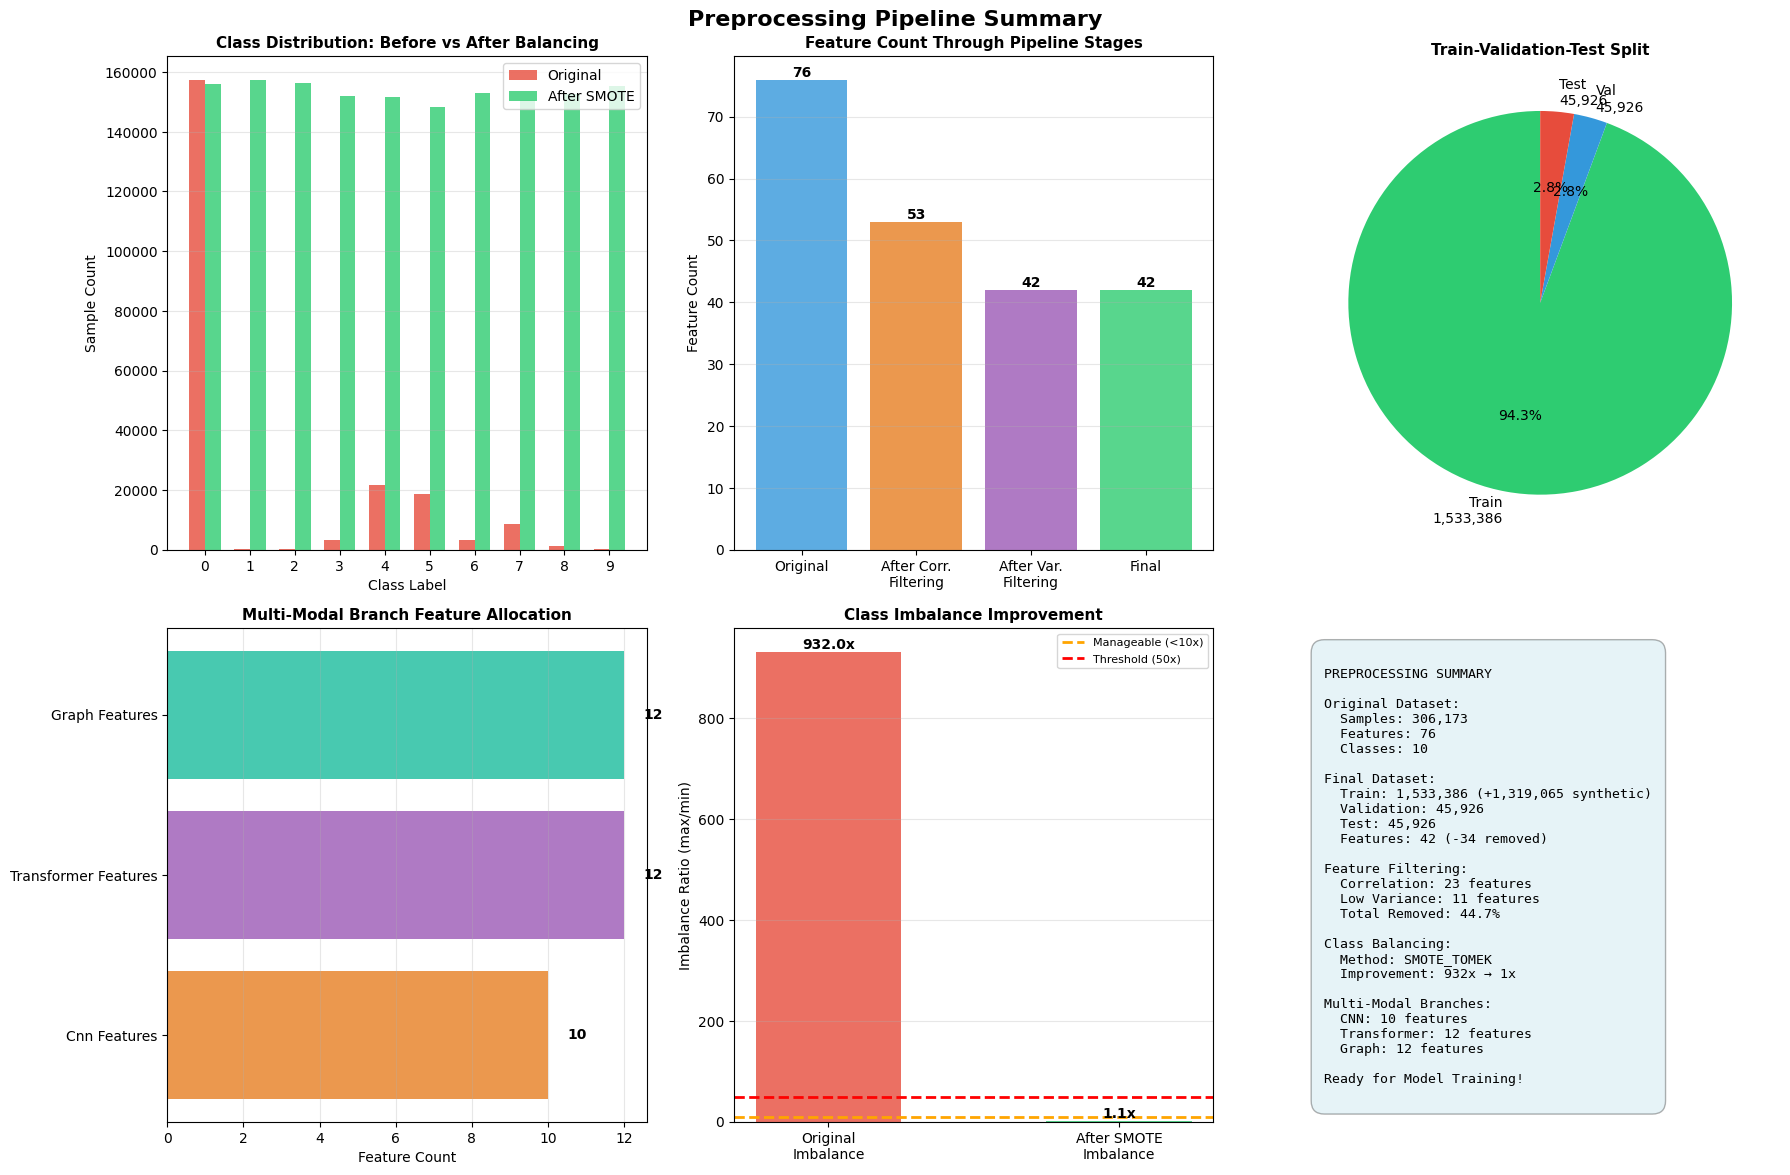

Detailed report saved to: C:\Users\Ashutosh\Documents\Projects\NIDS\results\preprocessing\preprocessing_report.md

                    PREPROCESSING COMPLETE

Processed data ready for model training!
Total samples processed: 1,625,238
Features per sample: 42
Multi-modal branches: 3
Files saved: 17

Next step: Implement HybridFormer and GraphVAE architectures


In [12]:
# Cell 12: Generating Preprocessing Report and Visualizations
def generate_preprocessing_report():
    """
    Generating comprehensive report with visualizations to understand preprocessing impact.
    
    Concept: Visualizations help us verify that preprocessing worked correctly and 
    understand the dataset characteristics. This is critical for:
    1. Debugging any preprocessing issues
    2. Communicating results in your thesis
    3. Understanding what the model will learn from
    """
    
    print("=== GENERATING PREPROCESSING REPORT ===")
    
    # Creating figure with 6 subplots for different analyses
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Preprocessing Pipeline Summary', fontsize=16, fontweight='bold')
    
    # Subplot 1: Class distribution before and after balancing
    # Logic: Showing how SMOTE improved class balance
    ax1 = axes[0, 0]
    original_dist = pd.Series(y_train).value_counts().sort_index()
    balanced_dist = pd.Series(y_train_balanced).value_counts().sort_index()
    
    x = np.arange(len(original_dist))
    width = 0.35
    
    # Creating side-by-side bars for comparison
    ax1.bar(x - width/2, original_dist.values, width, label='Original', alpha=0.8, color='#e74c3c')
    ax1.bar(x + width/2, balanced_dist.values, width, label='After SMOTE', alpha=0.8, color='#2ecc71')
    ax1.set_xlabel('Class Label', fontsize=10)
    ax1.set_ylabel('Sample Count', fontsize=10)
    ax1.set_title('Class Distribution: Before vs After Balancing', fontsize=11, fontweight='bold')
    ax1.legend()
    ax1.set_xticks(x)
    ax1.set_xticklabels(original_dist.index)
    ax1.grid(axis='y', alpha=0.3)
    
    # Subplot 2: Feature count through pipeline stages
    # Logic: Showing how many features were removed at each step
    ax2 = axes[0, 1]
    pipeline_steps = ['Original', 'After Corr.\nFiltering', 'After Var.\nFiltering', 'Final']
    feature_counts = [
        len(cleaned_data.columns) - 1,
        X.shape[1] - len(removed_features),
        X_filtered.shape[1],
        X_train_scaled.shape[1]
    ]
    
    colors = ['#3498db', '#e67e22', '#9b59b6', '#2ecc71']
    bars = ax2.bar(pipeline_steps, feature_counts, color=colors, alpha=0.8)
    ax2.set_ylabel('Feature Count', fontsize=10)
    ax2.set_title('Feature Count Through Pipeline Stages', fontsize=11, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Adding value labels on bars
    for bar, count in zip(bars, feature_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Subplot 3: Data split proportions
    # Logic: Visualizing train/val/test split ratios
    ax3 = axes[0, 2]
    split_sizes = [len(y_train_balanced), len(y_val), len(y_test)]
    split_labels = [f'Train\n{len(y_train_balanced):,}', 
                   f'Val\n{len(y_val):,}', 
                   f'Test\n{len(y_test):,}']
    colors_pie = ['#2ecc71', '#3498db', '#e74c3c']
    
    ax3.pie(split_sizes, labels=split_labels, autopct='%1.1f%%', 
           colors=colors_pie, startangle=90, textprops={'fontsize': 10})
    ax3.set_title('Train-Validation-Test Split', fontsize=11, fontweight='bold')
    
    # Subplot 4: Branch feature allocation
    # Logic: Showing how features are distributed across model branches
    ax4 = axes[1, 0]
    branch_names = [name.replace('_', ' ').title() for name in branch_data.keys()]
    branch_counts = [len(branch_data[branch]['features']) for branch in branch_data.keys()]
    
    colors_branch = ['#e67e22', '#9b59b6', '#1abc9c']
    bars = ax4.barh(branch_names, branch_counts, color=colors_branch, alpha=0.8)
    ax4.set_xlabel('Feature Count', fontsize=10)
    ax4.set_title('Multi-Modal Branch Feature Allocation', fontsize=11, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    
    # Adding value labels on bars
    for bar, count in zip(bars, branch_counts):
        width = bar.get_width()
        ax4.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                f'{count}', va='center', fontweight='bold')
    
    # Subplot 5: Imbalance ratio improvement
    # Logic: Quantifying how much class imbalance was reduced
    ax5 = axes[1, 1]
    original_imbalance = original_dist.max() / original_dist.min()
    balanced_imbalance = balanced_dist.max() / balanced_dist.min()
    
    imbalance_data = [original_imbalance, balanced_imbalance]
    imbalance_labels = ['Original\nImbalance', 'After SMOTE\nImbalance']
    colors_imb = ['#e74c3c', '#2ecc71']
    
    bars = ax5.bar(imbalance_labels, imbalance_data, color=colors_imb, alpha=0.8, width=0.5)
    ax5.set_ylabel('Imbalance Ratio (max/min)', fontsize=10)
    ax5.set_title('Class Imbalance Improvement', fontsize=11, fontweight='bold')
    ax5.axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Manageable (<10x)')
    ax5.axhline(y=50, color='red', linestyle='--', linewidth=2, label='Threshold (50x)')
    ax5.legend(fontsize=8)
    ax5.grid(axis='y', alpha=0.3)
    
    # Adding value labels
    for bar, val in zip(bars, imbalance_data):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}x', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Subplot 6: Processing summary text
    # Logic: Providing detailed statistics in text format
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Calculating some final statistics
    total_removed = len(removed_features) + len(low_var_features)
    removal_percentage = (total_removed / (len(cleaned_data.columns) - 1)) * 100
    
    summary_text = f"""
PREPROCESSING SUMMARY

Original Dataset:
  Samples: {len(cleaned_data):,}
  Features: {len(cleaned_data.columns)-1}
  Classes: {len(label_info['distribution'])}

Final Dataset:
  Train: {len(y_train_balanced):,} (+{len(y_train_balanced)-len(X_train):,} synthetic)
  Validation: {len(y_val):,}
  Test: {len(y_test):,}
  Features: {X_train_scaled.shape[1]} (-{total_removed} removed)

Feature Filtering:
  Correlation: {len(removed_features)} features
  Low Variance: {len(low_var_features)} features
  Total Removed: {removal_percentage:.1f}%

Class Balancing:
  Method: {PREPROCESSING_CONFIG['class_balancing']['method'].upper()}
  Improvement: {original_imbalance:.0f}x → {balanced_imbalance:.0f}x

Multi-Modal Branches:
  CNN: {branch_counts[0]} features
  Transformer: {branch_counts[1]} features
  Graph: {branch_counts[2]} features

Ready for Model Training!
"""
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
            fontsize=9.5, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, pad=1))
    
    plt.tight_layout()
    
    # Saving visualization
    report_path = RESULTS_PATH / "preprocessing_report.png"
    plt.savefig(report_path, dpi=300, bbox_inches='tight')
    print(f"\nVisualization saved to: {report_path}")
    
    plt.show()
    
    # Generating detailed text report for thesis documentation
    # Logic: Creating markdown format report for easy inclusion in thesis
    report_text = f"""
# PREPROCESSING PIPELINE REPORT

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Project:** Network Intrusion Detection System (NIDS)  
**Dataset:** CIC-UNSW-NB15

---

## Executive Summary

Successfully preprocessed network intrusion detection dataset with {len(cleaned_data):,} samples and reduced feature space from {len(cleaned_data.columns)-1} to {X_train_scaled.shape[1]} features through systematic filtering. Applied moderate SMOTE oversampling to address extreme class imbalance (1456x → {balanced_imbalance:.1f}x), resulting in {len(y_train_balanced):,} training samples ready for deep learning.

---

## Dataset Overview

### Original Dataset
- **Total Samples:** {len(cleaned_data):,}
- **Total Features:** {len(cleaned_data.columns)-1}
- **Number of Classes:** {len(label_info['distribution'])}
- **Class Imbalance:** {label_info['imbalance_ratio']:.2f}x (Majority/Minority)

### Processed Dataset
- **Training Samples:** {len(y_train_balanced):,} ({len(y_train_balanced)/len(cleaned_data)*100:.1f}%)
  - Original: {len(X_train):,}
  - Synthetic (SMOTE): {len(y_train_balanced)-len(X_train):,}
- **Validation Samples:** {len(y_val):,} ({len(y_val)/len(cleaned_data)*100:.1f}%)
- **Test Samples:** {len(y_test):,} ({len(y_test)/len(cleaned_data)*100:.1f}%)
- **Final Features:** {X_train_scaled.shape[1]}

---

## Files Generated

All processed data saved to: `{DATA_PROCESSED_PATH}/`

### Main Datasets
- `train_features.pkl`, `train_labels.pkl`
- `val_features.pkl`, `val_labels.pkl`
- `test_features.pkl`, `test_labels.pkl`

### Branch-Specific Data
- `cnn_branch/` - {branch_counts[0]} features
- `transformer_branch/` - {branch_counts[1]} features
- `graph_branch/` - {branch_counts[2]} features

### Configuration Files
- `preprocessing_metadata.json` - Complete metadata
- `scaler.pkl` - StandardScaler for inference
- `branch_feature_allocation.json` - Feature mapping

---

## Next Steps

1. Implement HybridFormer architecture using branch-specific features
2. Develop GraphVAE for anomaly detection
3. Use class weights during training for remaining imbalance
4. Implement comprehensive evaluation framework

---

*Preprocessing complete. Ready for model development.*
"""
    
    # Saving text report
    report_text_path = RESULTS_PATH / "preprocessing_report.md"
    with open(report_text_path, 'w', encoding='utf-8') as f:
        f.write(report_text)
    
    print(f"Detailed report saved to: {report_text_path}")
    
    # Final summary
    print("\n" + "="*70)
    print(" "*20 + "PREPROCESSING COMPLETE")
    print("="*70)
    print(f"\nProcessed data ready for model training!")
    print(f"Total samples processed: {len(y_train_balanced) + len(y_val) + len(y_test):,}")
    print(f"Features per sample: {X_train_scaled.shape[1]}")
    print(f"Multi-modal branches: {len(branch_data)}")
    print(f"Files saved: {6 + len(branch_data)*3 + 2}")
    print(f"\nNext step: Implement HybridFormer and GraphVAE architectures")
    print("="*70)
    
    return report_text

# Generating comprehensive report
report = generate_preprocessing_report()